# **Homework 11 - Generative Adversarial Network**

若有任何問題，歡迎來信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com

# Prepare Data


定義我們的 dataset，由於我們之後要使用 torchvision 這個套件來存圖片，因此我們會在這裡將 cv2 讀進來的圖片（BGR）轉成 torchvision 的格式（RGB）。

定義 preprocess: 將 input 形狀 resize 到 (64, 64)，並且將其 value 由 0\~1 線性轉換到 -1~1。

In [1]:
from torch.utils.data import Dataset, DataLoader
import cv2
import os

class FaceDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)
    def __getitem__(self,idx):
        fname = self.fnames[idx]
        img = cv2.imread(fname)  #讀入圖片
        img = self.BGR2RGB(img)  #because "torchvision.utils.save_image" use RGB
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples

    def BGR2RGB(self,img):
        return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

import glob
import torchvision.transforms as transforms

def get_dataset(root):  #將資料進行前處理
    fnames = glob.glob(os.path.join(root, '*'))
    # resize the image to (64, 64)
    # linearly map [0, 1] to [-1, 1]
    transform = transforms.Compose( #將圖片縮放及正規化
        [transforms.ToPILImage(),
         transforms.Resize((64, 64)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3) ] )
    dataset = FaceDataset(fnames, transform)
    return dataset

# Some useful functions
這裡我們提供固定 random seed 的函數，以便 reproduce。

In [2]:
import random
import torch
import numpy as np

def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


# Model
以 baseline mode 進行改寫。 

我們使用 DCGAN 作為 baseline mode。圖示為 DCGAN 架構示意圖。圖中的數字僅供參考。

# WGAN-GP

在真實資料及生成資料加入了 Gradient Penalty 
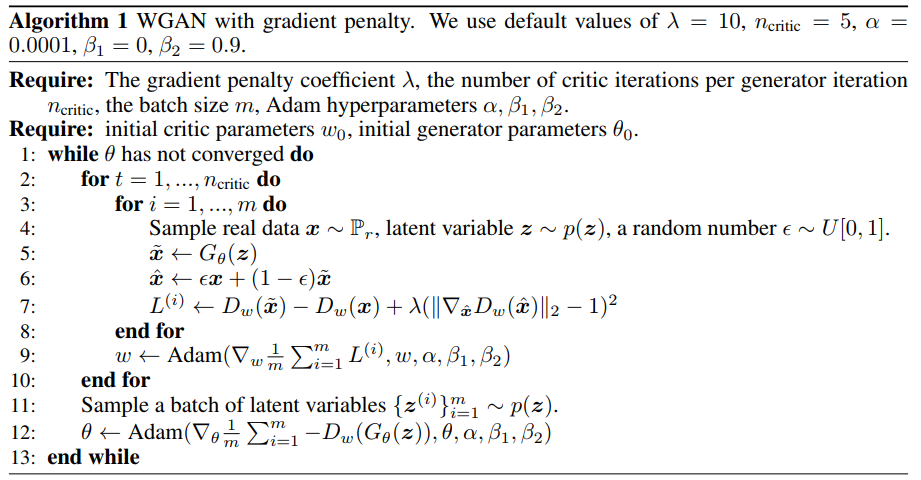

In [3]:
import torch.autograd as autograd
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # 在生成資料增加隨機雜訊
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # x hat = alpha * x + (1-alpha) * x lambda
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0]).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1) #
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [4]:
import torch.nn as nn
import torch.nn.functional as F

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Generator(nn.Module):
    """
    input (N, in_dim)
    output (N, 3, 64, 64)
    """
    def __init__(self, in_dim, dim=64):
        super(Generator, self).__init__()
        def dconv_bn_relu(in_dim, out_dim):
            return nn.Sequential(
                nn.ConvTranspose2d(in_dim, out_dim, 5, 2, padding=2, output_padding=1, bias=False),
                nn.BatchNorm2d(out_dim),
                nn.ReLU())
        self.l1 = nn.Sequential(
            nn.Linear(in_dim, dim * 8 * 4 * 4, bias=False),
            nn.BatchNorm1d(dim * 8 * 4 * 4),
            nn.ReLU())
        self.l2_5 = nn.Sequential(
            dconv_bn_relu(dim * 8, dim * 4),
            dconv_bn_relu(dim * 4, dim * 2),
            dconv_bn_relu(dim * 2, dim),
            nn.ConvTranspose2d(dim, 3, 5, 2, padding=2, output_padding=1),
            nn.Tanh())
        self.apply(weights_init)
    def forward(self, x):
        y = self.l1(x)
        y = y.view(y.size(0), -1, 4, 4)
        y = self.l2_5(y)
        return y

class Discriminator(nn.Module):
    """
    input (N, 3, 64, 64)
    output (N, )
    """
    def __init__(self, in_dim, dim=64):
        super(Discriminator, self).__init__()
        def conv_bn_lrelu(in_dim, out_dim):
            return nn.Sequential(
                nn.Conv2d(in_dim, out_dim, 5, 2, 2),
                nn.Dropout(0.5),
                nn.BatchNorm2d(out_dim),
                nn.LeakyReLU(0.2, inplace=True))
        self.ls = nn.Sequential(
            nn.Conv2d(in_dim, dim, 5, 2, 2), 
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            conv_bn_lrelu(dim, dim * 2),
            conv_bn_lrelu(dim * 2, dim * 4),
            conv_bn_lrelu(dim * 4, dim * 8),
            nn.Conv2d(dim * 8, 1, 4)) #linear output
        self.apply(weights_init)        
    def forward(self, x):
        y = self.ls(x)
        y = y.view(-1)
        return y

# Training

設定好 hyperparameters。
準備好 dataloader, model, loss criterion, optimizer。

In [5]:
import torch
from torch import optim
from torch.autograd import Variable
import torchvision

# hyperparameters 
batch_size = 64
z_dim = 100
lr = 1e-4
n_epoch = 150
save_dir = os.path.join('./', 'logs')
os.makedirs(save_dir, exist_ok=True)

# model
G = Generator(in_dim=z_dim).cuda()
D = Discriminator(3).cuda()
G.train()
D.train()

# optimizer
opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))


same_seeds(0)
# dataloader (You might need to edit the dataset path if you use extra dataset.)
dataset = get_dataset('faces')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


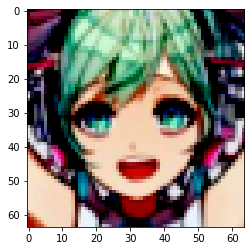

In [6]:
# 隨便印一張圖看看
import matplotlib.pyplot as plt
plt.imshow(dataset[10].numpy().transpose(1,2,0))

接下來就可以開始訓練了。我們定期儲存一些圖片，讓你觀察 Generator 目前的效果。並且定期紀錄 checkpoint。

In [ ]:
# for logging
z_sample = Variable(torch.randn(100, z_dim)).cuda()
lambda_gp = 10
for e, epoch in enumerate(range(n_epoch, 251)):
    for i, data in enumerate(dataloader):
        imgs = data
        imgs = imgs.cuda()
        D.zero_grad()
        bs = imgs.size(0)

        """ Train D """
        z = Variable(torch.randn(bs, z_dim)).cuda()
        r_imgs = Variable(imgs).cuda()
        f_imgs = G(z)

        # label        
        r_label = torch.ones((bs)).cuda()
        f_label = torch.zeros((bs)).cuda()

        # dis
        r_logit = D(r_imgs.detach())
        f_logit = D(f_imgs.detach())
        
        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(D, r_imgs.data, f_imgs.data)

        # compute loss
        loss_D = -torch.mean(r_logit) + torch.mean(f_logit) + lambda_gp * gradient_penalty
        
        # update model
        G.zero_grad()
        loss_D.backward()
        opt_D.step()
        
        #依據論文，Discriminator 更新n次後更新Generator
        if i % 5 == 0:
          """ train G """
          # leaf
          z = Variable(torch.randn(bs, z_dim)).cuda()
          f_imgs = G(z)

          # dis
          f_logit = D(f_imgs)
          
          # compute loss
          loss_G = -torch.mean(f_logit)

          # update model
          G.zero_grad()
          loss_G.backward()
          opt_G.step()
        
        # log
        print(f'\rEpoch [{epoch+1}/{n_epoch+100}] {i+1}/{len(dataloader)} Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f}', end='')
    G.eval()
    f_imgs_sample = (G(z_sample).data + 1) / 2.0
    filename = os.path.join(save_dir, f'Epoch_{epoch+1:03d}.jpg')
    torchvision.utils.save_image(f_imgs_sample, filename, nrow=10)
    print(f' | Save some samples to {filename}.')
    # show generated image
    grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
    plt.figure(figsize=(10,10))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()
    G.train()
    if (e+1) % 5 == 0:
        torch.save(G.state_dict(), f'wgan-gp_g.pth')
        torch.save(D.state_dict(), f'wgan-gp_d.pth')



# Inference
利用我們訓練好的 Generator 來隨機生成圖片。

In [8]:
import torch
# load pretrained model
G = Generator(z_dim)
G.load_state_dict(torch.load(os.path.join('./', 'wgan-gp_g.pth')))
G.eval()
G.cuda()

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=False)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (l2_5): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()


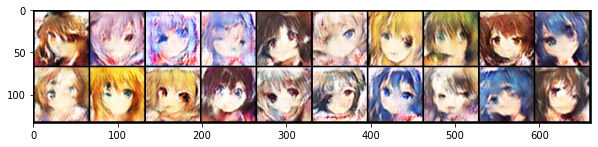

In [9]:
# generate images and save the result
n_output = 20
z_sample = Variable(torch.randn(n_output, z_dim)).cuda()
imgs_sample = (G(z_sample).data + 1) / 2.0
save_dir = os.path.join('./', 'logs')
filename = os.path.join(save_dir, f'result_{n_epoch}Epochs.jpg')
torchvision.utils.save_image(imgs_sample, filename, nrow=10)
# show image
grid_img = torchvision.utils.make_grid(imgs_sample.cpu(), nrow=10)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

In [13]:
import imageio
import glob
from PIL import Image
# filepaths
fp_in = "./logs/WGAN-GP/0609/Epoch_*.jpg"
fp_out = "./logs/WGAN-GP/0609/WGAN-GP_image_250.gif"

img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
imageio.mimsave(fp_out,imgs,fps=7)